## **Importação das bibliotecas e dados**

In [1]:
# %pip install ipykernel --break-system-packages
# %pip install scikit-learn --break-system-packages
# %pip install matplotlib --break-system-packages
# %pip install keras --break-system-packages
# %pip install tensorflow --break-system-packages
# %pip install pandas --break-system-packages
# %pip install plotly --break-system-packages
# %pip install seaborn --break-system-packages
# %pip install nbformat --break-system-packages
# %pip install keras --break-system-packages
# %pip install pswarm
# %pip install openpyxl --break-system-packages
# %pip install statsmodels --break-system-packages

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import grangercausalitytests

base_path = './dataset/'
time_base = 'days'
duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_3_{time_base}.csv'
volume_dataset = f'{base_path}volume/volume.xlsx'
volume_du_dataset = f'{base_path}volume/Volume - duas unas.xlsx'
validation_interval = 61
time_step = 1
output_steps = 60

In [3]:
duas_unas_df = pd.read_csv(duas_unas_dataset)

volume_du_df = pd.read_excel(volume_du_dataset)

duas_unas_df['timestamp'] = pd.to_datetime(duas_unas_df['timestamp'], errors='coerce')   # Dados de consumo de energia

volume_du_df['DATA'] = pd.to_datetime(volume_du_df['DATA'], errors='coerce')   # Dados de cota e pluviosidade

merged_du_df = pd.merge(duas_unas_df, volume_du_df, left_on='timestamp', right_on='DATA', how='inner')   # junção dos dataframes cujas linhas coincidem os parametros "DATA" e "timestamp". As demais são descartadas

final_du_df = merged_du_df[['timestamp', 'kWh fornecido', 'COTA']].rename(columns={   # Criação de dataframe apenas com as colunas "timestamp" "kWh fornecido" e "COTA". EM seguida, 2 colunas são renomeadas.
    'kWh fornecido': 'kwh',
    'COTA': 'cota'
})

du_df_sazon_tend_test = final_du_df.copy()

final_du_df['timestamp'] = final_du_df['timestamp'].dt.strftime('%Y%m%d').astype(int)   # Formata a coluna timestamp para o formato YYYYMMDD como um número inteiro

X = final_du_df[['timestamp', 'cota']]
y = final_du_df['kwh']

## **TESTES**

In [4]:
### TESTE DE PEARSON ###

# Adequado se você espera que a relação seja aproximadamente linear
correlation, p_value = pearsonr(final_du_df['cota'], final_du_df['kwh'])
print(f"correlation", correlation)
print(f"p_value", p_value)
# Valores próximos de +1 ou -1 indicam forte correlação positiva ou negativa,
# respectivamente, enquanto valores próximos de 0 indicam baixa ou nenhuma correlação linear

correlation -0.04014855746924106
p_value 0.6992780823390125


In [5]:
### TESTE DE SPEARMAN ###

correlation, p_value = spearmanr(final_du_df['cota'], final_du_df['kwh'])
print(f"correlation", correlation)
print(f"p_value", p_value)
# Valores próximos de +1 ou -1 indicam forte correlação monotônica positiva ou negativa,
# enquanto valores próximos de 0 indicam baixa ou nenhuma correlação.


correlation 0.4096533966890141
p_value 3.749711701068031e-05


In [6]:
### TESTE DE KENDALL TAU ###

correlation, p_value = kendalltau(final_du_df['cota'], final_du_df['kwh'])
print(f"correlation", correlation)
print(f"p_value", p_value)
# Valores próximos de +1 ou -1 indicam forte relação ordinal entre as variáveis


correlation 0.31048838116790817
p_value 8.585199858698945e-06


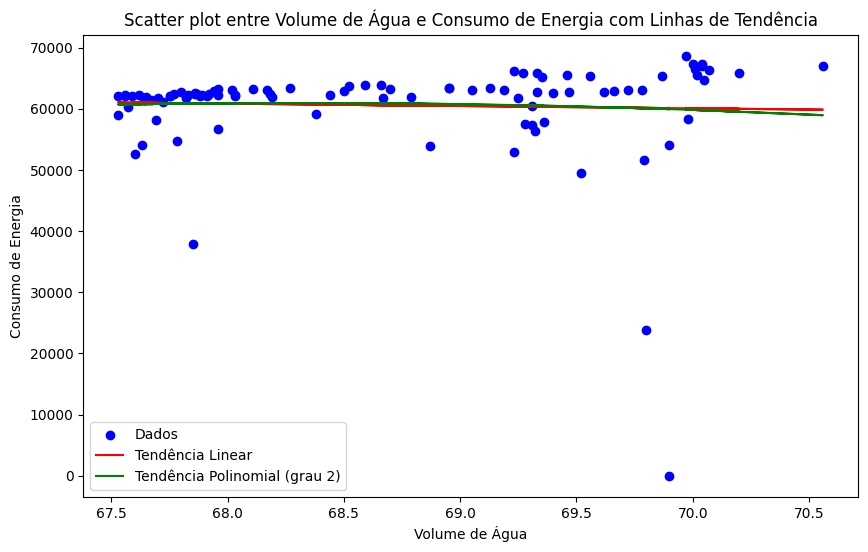

In [7]:
### GRÁFICO DE DISPERSÃO COM LINHA DE TENDÊNCIA LINEAR E POLINOMIAL

# Volume e Consumo de Energia
volume = final_du_df['cota'].values.reshape(-1, 1)
consumo = final_du_df['kwh'].values

# Gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(volume, consumo, color='blue', label='Dados')

# Linha de tendência linear
linear_model = LinearRegression()
linear_model.fit(volume, consumo)
linear_trend = linear_model.predict(volume)
plt.plot(volume, linear_trend, color='red', label='Tendência Linear')

# Linha de tendência polinomial (grau 2 como exemplo)
polynomial_coeffs = Polynomial.fit(volume.flatten(), consumo, deg=2).convert().coef
polynomial_trend = polynomial_coeffs[0] + polynomial_coeffs[1] * volume + polynomial_coeffs[2] * volume**2
plt.plot(volume, polynomial_trend, color='green', label='Tendência Polinomial (grau 2)')

# Configurações do gráfico
plt.xlabel('Volume de Água')
plt.ylabel('Consumo de Energia')
plt.title('Scatter plot entre Volume de Água e Consumo de Energia com Linhas de Tendência')
plt.legend()
plt.savefig(f'Scatter_plot.png')
plt.show()


In [8]:
### TESTE DE CAUSALIDADE DE GRANGER ###
# Avalia se o volume de água ajuda a prever o consumo de energia (causalidade temporal), 
# o que é particularmente útil em séries temporais

data = final_du_df[['kwh', 'cota']]
grangercausalitytests(data, maxlag=7)
# Um p-valor pequeno sugere que o volume de água pode ser um bom preditor do consumo de energia



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9348  , p=0.1676  , df_denom=91, df_num=1
ssr based chi2 test:   chi2=1.9985  , p=0.1575  , df=1
likelihood ratio test: chi2=1.9776  , p=0.1596  , df=1
parameter F test:         F=1.9348  , p=0.1676  , df_denom=91, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1960  , p=0.1173  , df_denom=88, df_num=2
ssr based chi2 test:   chi2=4.6415  , p=0.0982  , df=2
likelihood ratio test: chi2=4.5294  , p=0.1039  , df=2
parameter F test:         F=2.1960  , p=0.1173  , df_denom=88, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5092  , p=0.2180  , df_denom=85, df_num=3
ssr based chi2 test:   chi2=4.9004  , p=0.1792  , df=3
likelihood ratio test: chi2=4.7744  , p=0.1891  , df=3
parameter F test:         F=1.5092  , p=0.2180  , df_denom=85, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0552  , p=0.3841  , df_d

{np.int64(1): ({'ssr_ftest': (np.float64(1.9347500690039765),
    np.float64(0.16763148618280496),
    np.float64(91.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.9985330383117998),
    np.float64(0.15745152753366326),
    np.int64(1)),
   'lrtest': (np.float64(1.9775840536349278),
    np.float64(0.15964515321354344),
    np.int64(1)),
   'params_ftest': (np.float64(1.9347500690039894),
    np.float64(0.1676314861828012),
    np.float64(91.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.1959983857703795),
    np.float64(0.11730756915524579),
    np.float64(88.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.64154204265103),
    np.float64(0.09819784377715998),
    np.int64(2)),
   'lrtest': (np.float64(4.529429721411361),
    np.float64(0.10385964478489644),
    np.int64(2)),
   'params_ftest': (np.float64(2.1959983857703262),
    np.float64(0.11730756915525246),
    np.float64(88.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      

Testando Sazonalidade e Tendência do Volume de Água:
ADF Statistic: -1.1493586826941373
p-value: 0.6949925196907608
Critical Value (1%): -3.50434289821397
Critical Value (5%): -2.8938659630479413
Critical Value (10%): -2.5840147047458037
------------------------------


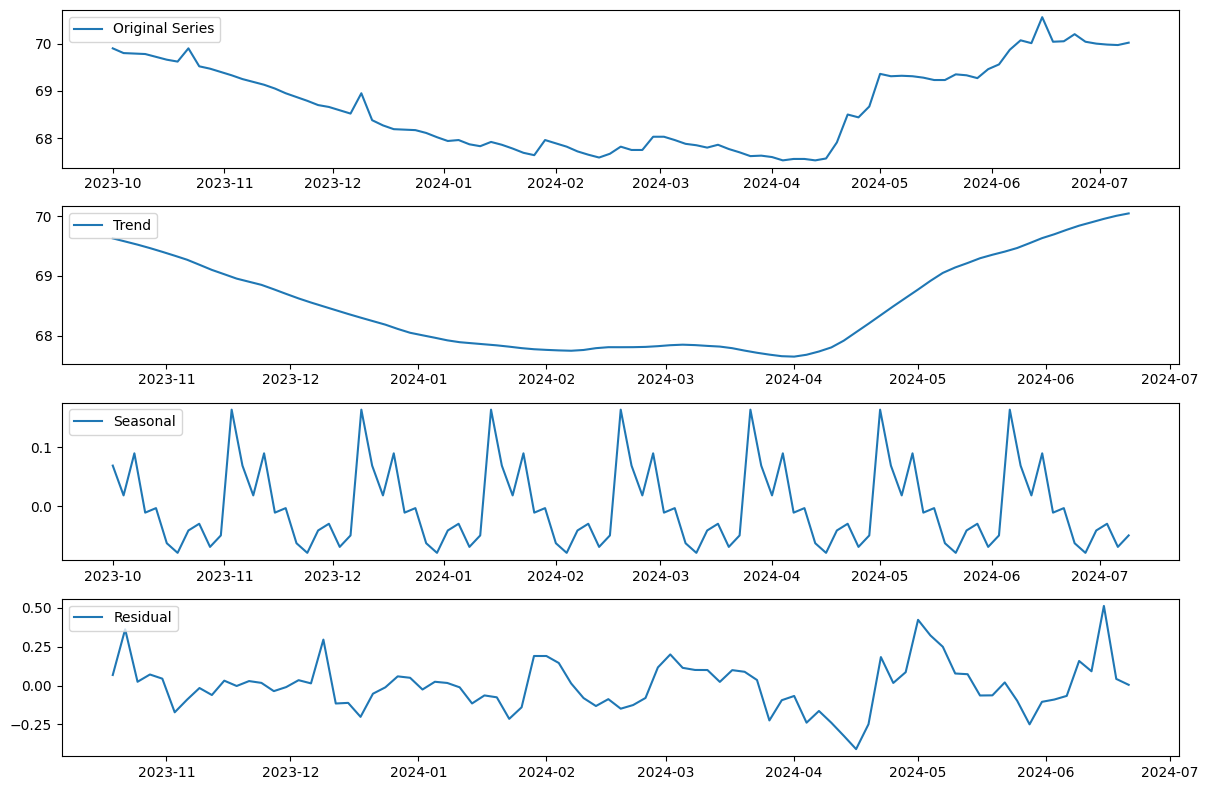

Testando Sazonalidade e Tendência do Consumo de Energia:
ADF Statistic: -10.31684197718174
p-value: 3.0814048923392584e-18
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781
------------------------------


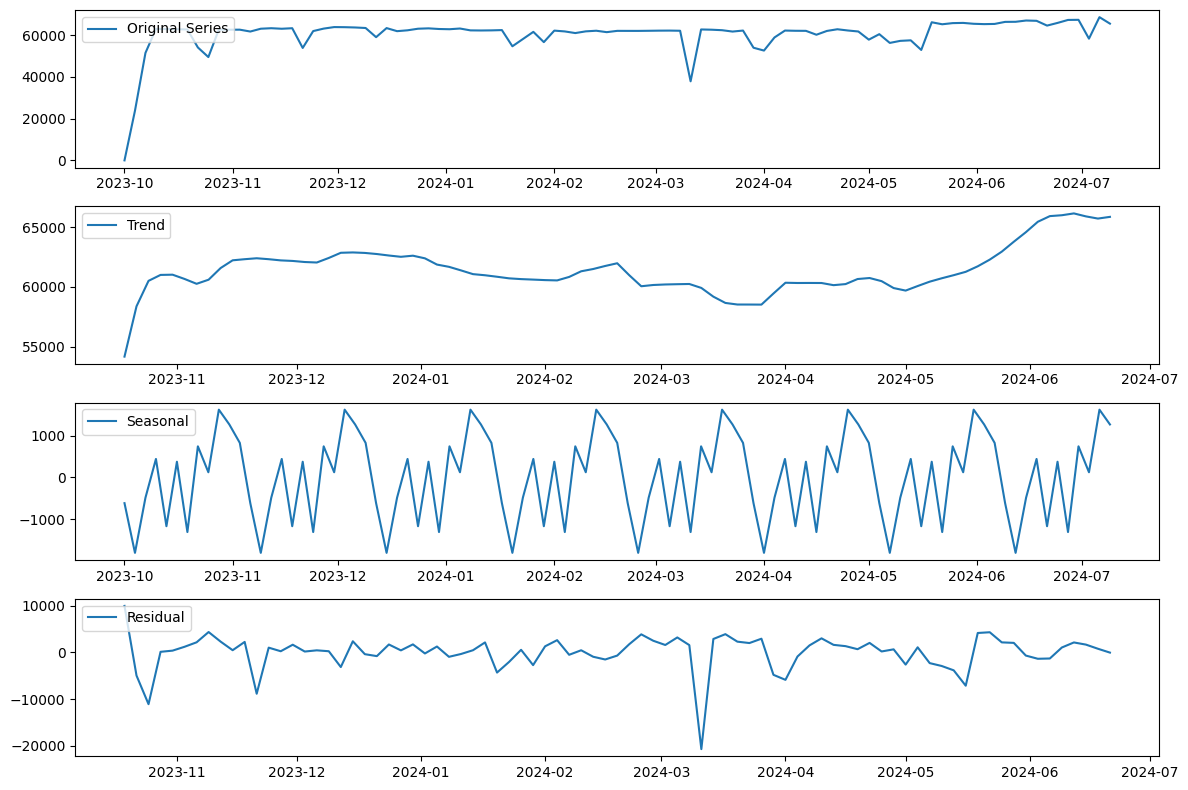

In [9]:
# DataFrame df com as colunas 'data', 'volume_agua', e 'consumo_energia'
df = du_df_sazon_tend_test.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Converter a coluna de data para o tipo datetime
df.set_index('timestamp', inplace=True)  # Definir a coluna de data como índice

# Função para testar a estacionaridade usando o teste ADF
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    # Um p-valor menor que 0.05 sugere que a série é estacionária
    for key, value in result[4].items():
        print(f'Critical Value ({key}):', value)
    print('---' * 10)

# Função para decompor a série temporal
def plot_decomposition(series, name):
    decomposition = seasonal_decompose(series, model='additive', period=12)  # Assumindo sazonalidade mensal
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(series, label='Original Series')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig(f'decomposition_{name}.png')
    plt.show()

# Analisando o volume de água
print("Testando Sazonalidade e Tendência do Volume de Água:")
test_stationarity(df['cota'])
plot_decomposition(df['cota'], 'cota')

# Analisando o consumo de energia
print("Testando Sazonalidade e Tendência do Consumo de Energia:")
test_stationarity(df['kwh'])
plot_decomposition(df['kwh'], 'kwh')
